# Evaluate a trained model

## Setup

```
jupyter nbextension enable --py widgetsnbextension
```

In [19]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pickle
import shutil
import sys

import azureml.core
from azureml.core import Workspace
from azureml.core.dataset import Dataset
import glob2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
from IPython.display import display, HTML

print("Azure ML SDK Version: ", azureml.core.VERSION)

sys.path.append(str(Path(os.getcwd()).parent / 'evaluation/QA/eval_depthmap_models/src'))

from eval_utils import calculate_performance, CODE_TO_SCANTYPE, CONFIG, REPO_DIR, preprocess_targets, preprocess_depthmap, tf_load_pickle, preprocess, extract_qrcode, extract_scantype, avgerror
from evaluate import predict_uncertainty, get_prediction_uncertainty

Azure ML SDK Version:  1.18.0


### Select the  model to be evaluated from workspace

In [ ]:
workspace = Workspace.from_config()

selected_experiments = ["q3-depthmap-plaincnn-height-95k"]

# RUN_ID = 'q3-depthmap-plaincnn-height-95k_1597988908_42c4ef33'  # Run3
RUN_ID = 'q3-depthmap-plaincnn-height-95k_1600451633_cb44f6db'  # Run17

OUTPUT_DIR = 'data/logs/q3-depthmap-plaincnn-height-95k/run_03/'

### Download the models on your local system for evaluation

### Load the models

In [ ]:
REPO_DIR

In [ ]:
MODEL_PATH = str(REPO_DIR / f"data/{RUN_ID}/best_model.h5")

model = load_model(MODEL_PATH)
# summarize model.
# model.summary()

### Show a sample from the testset

In [ ]:
# paths = '../testdepthmap1/1585551618-hlby208u8z/pc_1585551618-hlby208u8z_1593156356859_100_000.p'
paths = REPO_DIR / "data/anon-depthmap-testset/scans/1585013728-90norqfryy/100/pc_1585013728-90norqfryy_1591850340061_100_000.p"

depthmap, targets = pickle.load(open(paths, "rb"))
depthmap = preprocess_depthmap(depthmap)
depthmap = depthmap / depthmap.max()
print("depthmap_max:", depthmap.max())
depthmap = tf.image.resize(depthmap, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
depthmap.set_shape((CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1))
# targets.set_shape((len(targets_indices,)))
plt.imshow(np.squeeze(depthmap), cmap='gray');

## Dataset

To use the dataset, you can:
- mount the dataset
- use datastore (blob storage)
- download the dataset

Choose your preferred way and make sure to adjust the absolute path

In [22]:
# DATASET_PATH = '/mnt/depthmap/depthmap_testset/scans/*/*/'
DATASET_PATH = str(REPO_DIR / "data/anon-depthmap-testset/scans/*/*/")

### Perform the prediction

In [23]:
prediction_folder = glob2.glob(DATASET_PATH); prediction_folder[:3]

['/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-testset/scans/1585013299-lb13d119ep/102',
 '/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-testset/scans/1585013299-lb13d119ep/100',
 '/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-testset/scans/1585013299-lb13d119ep/101']

In [51]:
prediction_folder = prediction_folder[:10]  # reduce size for DEBUG speed

predictions = []
uncertainties = []
file_names = []
for qrcode in tqdm(prediction_folder):
    depthfiles = []
    depthmaps = glob2.glob(qrcode + '/*.p')
    files = depthmaps[0]
    depths, _ = preprocess(files)

    sample = np.expand_dims(depths, axis=0)
    
    inference = model.predict(sample)
    uncertainties.append(predict_uncertainty(sample, model))
    file_names.append(files)
    predictions.append(np.squeeze(inference))

In [36]:
IMAGE_TARGET_HEIGHT=240
IMAGE_TARGET_WIDTH=180
TARGET_INDEXES=[0]
def py_load_pickle(path, max_value=7.5):
    path_ = path if isinstance(path, str) else path.numpy()
    depthmap, targets = pickle.load(open(path_, "rb"))
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / max_value
    depthmap = tf.image.resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    targets = preprocess_targets(targets, TARGET_INDEXES)
    return depthmap, targets

def path_to_ndarray(pickle_file_path):
    depthmap, _targets = py_load_pickle(pickle_file_path)
    depthmap = tf.reshape(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    return depthmap.numpy(), _targets

In [49]:
predictions[0] # TODO should be 1 number

array(79.58651, dtype=float32)

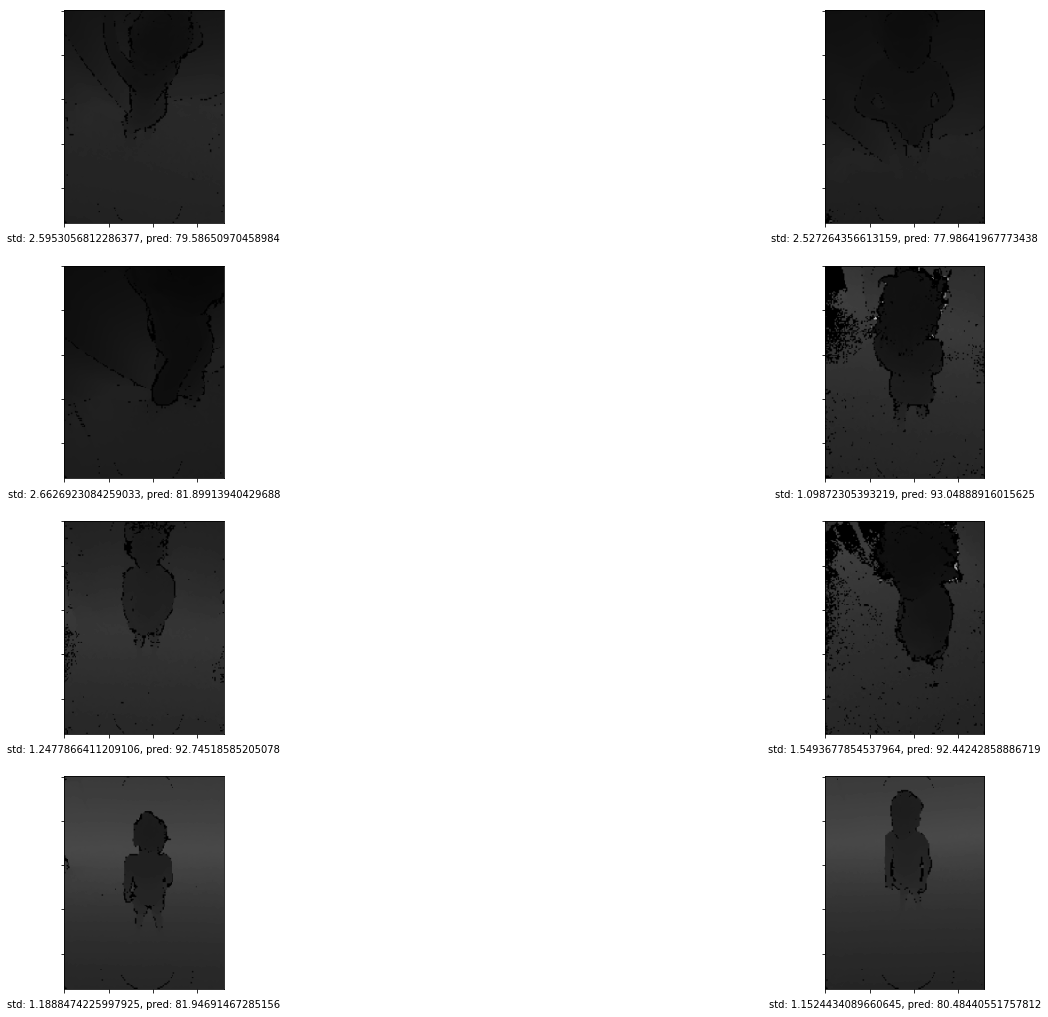

In [52]:
num_height, num_width = 4, 2
fig, axarr = plt.subplots(num_height, num_width, figsize=(25, 18))

for x in range(num_height):
    for y in range(num_width):
        i = x * num_width + y
        fpath = file_names[i]
        arr, targets = path_to_ndarray(fpath)
        axarr[x,y].imshow(arr, cmap='gray', vmin=0, vmax=1); 
        axarr[x,y].set_xticklabels([])
        axarr[x,y].set_yticklabels([])
        
        label = f"std: {uncertainties[i]}, pred: {predictions[i]}"
        axarr[x,y].set_xlabel(label)
#         axarr[x,y].set_xlabel(fname[-12:]+ f" is {targets[0]:.2f}cm")
plt.show()

In [38]:
# Put predictions into dataframe
df = pd.DataFrame([])
for i in tqdm(range(len(predictions))):
    label = np.array(predictions[i][3]).flatten()
    data = pd.DataFrame({
        'qrcode':predictions[i][0],
        'artifacts': predictions[i][1],
        'predicted':predictions[i][2],
        'GT':label,
    })
    df = df.append(data)
df.head()

,qrcode,artifacts,predicted,GT
0,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,79.586510,82.300003
1,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.762001,82.300003
2,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.641182,82.300003
3,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.757225,82.300003
4,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,81.590736,82.300003


In [ ]:
df['qrcode'] = df.apply(extract_qrcode, axis=1)
df.head()

In [ ]:
df['artifacts'].iloc[1]  # sample of how the artifacts path looks like for me, modify it accordingly to suit your path dependency

In [ ]:
len(df['qrcode'].unique()) ## total number of scans

In [ ]:
df['scantype'] = df.apply(extract_scantype, axis=1)
df['scantype'].value_counts()

### Group the results of artifacts by qrcode and scantype by taking mean across the same scantype

In [ ]:
MAE = df.groupby(['qrcode', 'scantype']).mean()
MAE

## Error between predicted and ground truth

In [ ]:
MAE['error'] = MAE.apply(avgerror, axis=1)
MAE

In [ ]:
# unique name for the index values
model_name = 'q3-depthmap-plaincnn-height-100-95k'
run_no ='_front_run_03'
complete_name = model_name + run_no; complete_name

## Calculate accuracies across the scantypes

In [ ]:
dfs = []
for code in CODE_TO_SCANTYPE.keys():
    df = calculate_performance(code, MAE)
    full_model_name = complete_name + CODE_TO_SCANTYPE[code]
    df.rename(index={0:full_model_name}, inplace=True)
    display(HTML(df.to_html()))
    dfs.append(df)

## Combine the results for all accuracies

In [ ]:
result = pd.concat(dfs)
result.index.name = 'Model_Scantype'
result = result.round(2)
result

In [ ]:
# Save the model results in csv file
CSV_OUT_PATH = REPO_DIR / 'data' / 'eval' / RUN_ID / 'result.csv'
Path(CSV_OUT_PATH.parent).mkdir(parents=True, exist_ok=True)
result.to_csv(CSV_OUT_PATH, index=True)